## Linear Algebra
A lot of the Data Science methods we will see in this tutorial require some understanding of linear algebra, and in this notebook we will focus on how Julia handles matrices, the types that exist, and how to call basic linear algebra tasks.

In [1]:
# some packages we will use
using LinearAlgebra
using SparseArrays
using Images
using MAT

![title](data/matrix_storage.png)
### 🟢Getting started

Due to how Matrices are stored, it will always be more efficient to access (for example with loops) the field of the matrix via the column first (i.e. a for-loop going through the columns will be faster than a for-loop going through the rows)

We will get started with creating a random matrix.

In [10]:
A = rand(3,3) # created a random matrix of size 3-by-3
Atranspose = A' # matrix transpose
A = A*Atranspose # matrix multiplication

3×3 Matrix{Float64}:
 1.44255   0.874898  1.05251
 0.874898  0.995562  0.955883
 1.05251   0.955883  1.02378

In [7]:
@show A[11] == A[1,2]; # works because of how matrices are stored, as you can see above

A[11] == A[1, 2] = true


In [14]:
@show b = rand(3); # created a random vector of size 3
@show x = A\b; # x is the solutions to the linear system Ax=b
# A \ b is generally more efficient than solving the linear system of equations with the inverse matrix
@show norm(A * x - b) # very close to zero, therefore the solution is correct
;

b = rand(3) = [0.4503594120444262, 0.18803689550326252, 0.23722554481541636]
x = A \ b = [0.6921951571732233, 0.3994165712395107, -0.8528312156999305]
norm(A * x - b) = 6.798699777552591e-17


A few things that are noteworthy: 
- `A` is a `Matrix` type, and `b` is a `Vector` type.
- The transpose function creates a matrix of type `Adjoint`.
- `\` is always the recommended way to solve a linear system. You almost never want to call the `inv` function

In [17]:
@show typeof(A)
@show typeof(b)
@show typeof(rand(1,10))
@show typeof(Atranspose)
;
# Matrix = 2-D Array
# Vector = 1-D Array
# Array with several columns => Matrix
# rand(10, 1) => Matrix, because column-size is declared
# rand(10) => Vector

typeof(A) = Matrix{Float64}
typeof(b) = Vector{Float64}
typeof(rand(1, 10)) = Matrix{Float64}
typeof(Atranspose) = Adjoint{Float64, Matrix{Float64}}


In [18]:
Matrix{Float64} == Array{Float64,2}

true

In [19]:
Vector{Float64} == Array{Float64,1}

true

In [20]:
Atranspose

3×3 adjoint(::Matrix{Float64}) with eltype Float64:
 0.56859   0.0998598  0.0887547
 0.636929  0.962658   0.845431
 0.844735  0.242649   0.548774

`adjoint` in julia is a lazy adjoint -- often, we can easily perform Linear Algebra operations such as `A*A'` without actually transposing the matrix.

In [21]:
?adjoint

search: adjoint adjoint! Adjoint



```
A'
adjoint(A)
```

Lazy adjoint (conjugate transposition). Note that `adjoint` is applied recursively to elements.

For number types, `adjoint` returns the complex conjugate, and therefore it is equivalent to the identity function for real numbers.

This operation is intended for linear algebra usage - for general data manipulation see [`permutedims`](@ref Base.permutedims).

# Examples

```jldoctest
julia> A = [3+2im 9+2im; 8+7im  4+6im]
2×2 Matrix{Complex{Int64}}:
 3+2im  9+2im
 8+7im  4+6im

julia> adjoint(A)
2×2 adjoint(::Matrix{Complex{Int64}}) with eltype Complex{Int64}:
 3-2im  8-7im
 9-2im  4-6im

julia> x = [3, 4im]
2-element Vector{Complex{Int64}}:
 3 + 0im
 0 + 4im

julia> x'x
25 + 0im
```


In [22]:
Atranspose.parent

3×3 Matrix{Float64}:
 0.56859    0.636929  0.844735
 0.0998598  0.962658  0.242649
 0.0887547  0.845431  0.548774

In [24]:
sizeof(A) # gives size in bytes

72

That's because it's an array of Float64's, each is of size 8 bytes, and there are 3\*3 numbers. 3\*3*8 = 72.

In [25]:
# To actually copy the matrix:
B = copy(Atranspose)

3×3 Matrix{Float64}:
 0.56859   0.0998598  0.0887547
 0.636929  0.962658   0.845431
 0.844735  0.242649   0.548774

In [26]:
sizeof(B)

72

The `\` operator allows you to solve a system of linear equations, and often uses a suitable matrix factorization to solve the problem. We will cover factorizations next.

In [27]:
?\

search: \



```
\(x, y)
```

Left division operator: multiplication of `y` by the inverse of `x` on the left. Gives floating-point results for integer arguments.

# Examples

```jldoctest
julia> 3 \ 6
2.0

julia> inv(3) * 6
2.0

julia> A = [4 3; 2 1]; x = [5, 6];

julia> A \ x
2-element Vector{Float64}:
  6.5
 -7.0

julia> inv(A) * x
2-element Vector{Float64}:
  6.5
 -7.0
```

---

```
\(A, B)
```

Matrix division using a polyalgorithm. For input matrices `A` and `B`, the result `X` is such that `A*X == B` when `A` is square. The solver that is used depends upon the structure of `A`.  If `A` is upper or lower triangular (or diagonal), no factorization of `A` is required and the system is solved with either forward or backward substitution. For non-triangular square matrices, an LU factorization is used.

For rectangular `A` the result is the minimum-norm least squares solution computed by a pivoted QR factorization of `A` and a rank estimate of `A` based on the R factor.

When `A` is sparse, a similar polyalgorithm is used. For indefinite matrices, the `LDLt` factorization does not use pivoting during the numerical factorization and therefore the procedure can fail even for invertible matrices.

See also: [`factorize`](@ref), [`pinv`](@ref).

# Examples

```jldoctest
julia> A = [1 0; 1 -2]; B = [32; -4];

julia> X = A \ B
2-element Vector{Float64}:
 32.0
 18.0

julia> A * X == B
true
```

---

```
(\)(F::QRSparse, B::StridedVecOrMat)
```

Solve the least squares problem $\min\|Ax - b\|^2$ or the linear system of equations $Ax=b$ when `F` is the sparse QR factorization of $A$. A basic solution is returned when the problem is underdetermined.

# Examples

```jldoctest
julia> A = sparse([1,2,4], [1,1,1], [1.0,1.0,1.0], 4, 2)
4×2 SparseMatrixCSC{Float64, Int64} with 3 stored entries:
 1.0   ⋅
 1.0   ⋅
  ⋅    ⋅
 1.0   ⋅

julia> qr(A)\fill(1.0, 4)
2-element Vector{Float64}:
 1.0
 0.0
```


### 🟢Factorizations
A common tool used in Linear Algebra is matrix factorizations. These factorizations are often used to solve linear systems like `Ax=b`, and as we will see later in this tutorial... `Ax=b` comes up in a lot of Data Science problems

#### LU factorization
L\*U = P\*A

In [28]:
luA = lu(A)

LU{Float64, Matrix{Float64}}
L factor:
3×3 Matrix{Float64}:
 1.0       0.0       0.0
 0.606494  1.0       0.0
 0.729619  0.682969  1.0
U factor:
3×3 Matrix{Float64}:
 1.44255  0.874898  1.05251
 0.0      0.464941  0.317541
 0.0      0.0       0.0389789

In [29]:
norm(luA.L*luA.U - luA.P*A)

1.1102230246251565e-16

#### QR factorization
Q\*R = A

In [30]:
qrA = qr(A)

LinearAlgebra.QRCompactWY{Float64, Matrix{Float64}}
Q factor:
3×3 LinearAlgebra.QRCompactWYQ{Float64, Matrix{Float64}}:
 -0.725442   0.640474  -0.252046
 -0.439976  -0.713126  -0.545777
 -0.529297  -0.285036   0.799124
R factor:
3×3 Matrix{Float64}:
 -1.98851  -1.57866   -1.72599
  0.0      -0.422072  -0.299373
  0.0       0.0        0.031149

In [31]:
norm(qrA.Q*qrA.R - A)

5.978733960281817e-16

#### Cholesky factorization, note that A needs to be symmetric positive definite
L\*L' = A 

In [37]:
isposdef(A) # this factorization only works on positive definites

true

In [38]:
cholA = cholesky(A)

Cholesky{Float64, Matrix{Float64}}
U factor:
3×3 UpperTriangular{Float64, Matrix{Float64}}:
 1.20106  0.728437  0.876318
  ⋅       0.681866  0.465694
  ⋅        ⋅        0.197431

In [39]:
norm(cholA.L*cholA.U - A)

1.1102230246251565e-16

In [40]:
cholA.L

3×3 LowerTriangular{Float64, Matrix{Float64}}:
 1.20106    ⋅         ⋅ 
 0.728437  0.681866   ⋅ 
 0.876318  0.465694  0.197431

In [41]:
cholA.U

3×3 UpperTriangular{Float64, Matrix{Float64}}:
 1.20106  0.728437  0.876318
  ⋅       0.681866  0.465694
  ⋅        ⋅        0.197431

In [42]:
factorize(A)

Cholesky{Float64, Matrix{Float64}}
U factor:
3×3 UpperTriangular{Float64, Matrix{Float64}}:
 1.20106  0.728437  0.876318
  ⋅       0.681866  0.465694
  ⋅        ⋅        0.197431

In [43]:
?factorize

search: factorize Factorization factorial



```
factorize(A)
```

Compute a convenient factorization of `A`, based upon the type of the input matrix. `factorize` checks `A` to see if it is symmetric/triangular/etc. if `A` is passed as a generic matrix. `factorize` checks every element of `A` to verify/rule out each property. It will short-circuit as soon as it can rule out symmetry/triangular structure. The return value can be reused for efficient solving of multiple systems. For example: `A=factorize(A); x=A\b; y=A\C`.

| Properties of `A`          | type of factorization                      |
|:-------------------------- |:------------------------------------------ |
| Positive-definite          | Cholesky (see [`cholesky`](@ref))          |
| Dense Symmetric/Hermitian  | Bunch-Kaufman (see [`bunchkaufman`](@ref)) |
| Sparse Symmetric/Hermitian | LDLt (see [`ldlt`](@ref))                  |
| Triangular                 | Triangular                                 |
| Diagonal                   | Diagonal                                   |
| Bidiagonal                 | Bidiagonal                                 |
| Tridiagonal                | LU (see [`lu`](@ref))                      |
| Symmetric real tridiagonal | LDLt (see [`ldlt`](@ref))                  |
| General square             | LU (see [`lu`](@ref))                      |
| General non-square         | QR (see [`qr`](@ref))                      |

If `factorize` is called on a Hermitian positive-definite matrix, for instance, then `factorize` will return a Cholesky factorization.

# Examples

```jldoctest
julia> A = Array(Bidiagonal(fill(1.0, (5, 5)), :U))
5×5 Matrix{Float64}:
 1.0  1.0  0.0  0.0  0.0
 0.0  1.0  1.0  0.0  0.0
 0.0  0.0  1.0  1.0  0.0
 0.0  0.0  0.0  1.0  1.0
 0.0  0.0  0.0  0.0  1.0

julia> factorize(A) # factorize will check to see that A is already factorized
5×5 Bidiagonal{Float64, Vector{Float64}}:
 1.0  1.0   ⋅    ⋅    ⋅
  ⋅   1.0  1.0   ⋅    ⋅
  ⋅    ⋅   1.0  1.0   ⋅
  ⋅    ⋅    ⋅   1.0  1.0
  ⋅    ⋅    ⋅    ⋅   1.0
```

This returns a `5×5 Bidiagonal{Float64}`, which can now be passed to other linear algebra functions (e.g. eigensolvers) which will use specialized methods for `Bidiagonal` types.


In [44]:
?diagm

search: diagm spdiagm diag diagind Diagonal isdiag Bidiagonal Tridiagonal



```
diagm(kv::Pair{<:Integer,<:AbstractVector}...)
diagm(m::Integer, n::Integer, kv::Pair{<:Integer,<:AbstractVector}...)
```

Construct a matrix from `Pair`s of diagonals and vectors. Vector `kv.second` will be placed on the `kv.first` diagonal. By default the matrix is square and its size is inferred from `kv`, but a non-square size `m`×`n` (padded with zeros as needed) can be specified by passing `m,n` as the first arguments.

`diagm` constructs a full matrix; if you want storage-efficient versions with fast arithmetic, see [`Diagonal`](@ref), [`Bidiagonal`](@ref) [`Tridiagonal`](@ref) and [`SymTridiagonal`](@ref).

# Examples

```jldoctest
julia> diagm(1 => [1,2,3])
4×4 Matrix{Int64}:
 0  1  0  0
 0  0  2  0
 0  0  0  3
 0  0  0  0

julia> diagm(1 => [1,2,3], -1 => [4,5])
4×4 Matrix{Int64}:
 0  1  0  0
 4  0  2  0
 0  5  0  3
 0  0  0  0
```

---

```
diagm(v::AbstractVector)
diagm(m::Integer, n::Integer, v::AbstractVector)
```

Construct a matrix with elements of the vector as diagonal elements. By default, the matrix is square and its size is given by `length(v)`, but a non-square size `m`×`n` can be specified by passing `m,n` as the first arguments.

# Examples

```jldoctest
julia> diagm([1,2,3])
3×3 Matrix{Int64}:
 1  0  0
 0  2  0
 0  0  3
```


In [45]:
# convert(Diagonal{Int64,Array{Int64,1}},diagm([1,2,3]))
Diagonal([1,2,3])

3×3 Diagonal{Int64, Vector{Int64}}:
 1  ⋅  ⋅
 ⋅  2  ⋅
 ⋅  ⋅  3

`I` is a function

In [50]:
I(3)

3×3 Diagonal{Bool, Vector{Bool}}:
 1  ⋅  ⋅
 ⋅  1  ⋅
 ⋅  ⋅  1

In [51]:
# I automatically picks the right dimension:
A + I

3×3 Matrix{Float64}:
 2.44255   0.874898  1.05251
 0.874898  1.99556   0.955883
 1.05251   0.955883  2.02378

### 🟢Sparse Linear Algebra
Sparse matrices are stored in Compressed Sparse Column (CSC) form

In [52]:
using SparseArrays
S = sprand(5,5,2/5)

5×5 SparseMatrixCSC{Float64, Int64} with 9 stored entries:
  ⋅        0.899486   ⋅         ⋅         ⋅ 
 0.80333    ⋅        0.444735  0.118313   ⋅ 
  ⋅         ⋅         ⋅         ⋅         ⋅ 
 0.196522   ⋅         ⋅         ⋅        0.659689
 0.151801   ⋅        0.834734  0.272893   ⋅ 

In [64]:
Matrix(S) # basically de-sparsing the sparse matrix

5×5 Matrix{Float64}:
 0.0       0.899486  0.0       0.0       0.0
 0.80333   0.0       0.444735  0.118313  0.0
 0.0       0.0       0.0       0.0       0.0
 0.196522  0.0       0.0       0.0       0.659689
 0.151801  0.0       0.834734  0.272893  0.0

In [65]:
S.rowval # Vector giving the index of the value in the row.
# The column of the value can only be deduced in combination with S.colptr

9-element Vector{Int64}:
 2
 4
 5
 1
 2
 5
 2
 5
 4

In [56]:
S.colptr # Vector giving the index of S.rowval for the specific column

6-element Vector{Int64}:
  1
  4
  5
  7
  9
 10

In [59]:
S.nzval # Actual values in the matrix

9-element Vector{Float64}:
 0.8033301510526305
 0.19652209328270398
 0.15180067529149444
 0.8994856142845203
 0.4447354620720906
 0.8347338011319064
 0.1183129751997184
 0.27289270791509035
 0.6596888450768233

In [62]:
S.m # dimension of row-space

5

In [63]:
S.n # dimension of column-space

5

### 🟢Images as matrices
Let's get to the more "data science-y" side. We will do so by working with images (which can be viewed as matrices), and we will use the `SVD` decomposition.

First let's load an image. I chose this image as it has a lot of details.

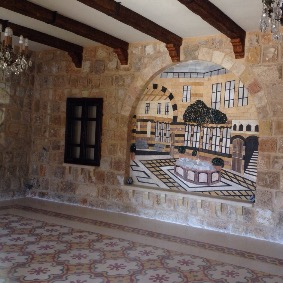

In [66]:
X1 = load("data/khiam-small.jpg")

In [67]:
@show typeof(X1)
X1[1,1] # this is pixel [1,1]

typeof(X1) = Matrix{RGB{N0f8}}


We can easily convert this image to gray scale.

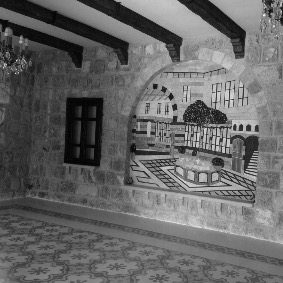

In [68]:
Xgray = Gray.(X1)

We can easily extract the RGB layers from the image. We will make use of the `reshape` function below to reshape a vector to a matrix.

In [69]:
R = map(i->X1[i].r,1:length(X1))
R = Float64.(reshape(R,size(X1)...))

G = map(i->X1[i].g,1:length(X1))
G = Float64.(reshape(G,size(X1)...))

B = map(i->X1[i].b,1:length(X1))
B = Float64.(reshape(B,size(X1)...))
;

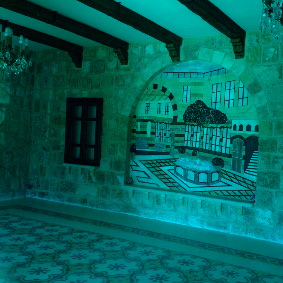

In [79]:
Z = zeros(size(R)...) # just a matrix of all zeros of equal size as the image
RGB.(Z,G,B)

We can easily obtain the `Float64` values of the grayscale image.

In [81]:
Xgrayvalues = Float64.(Xgray) # Xgray = Gray.(X1)

283×283 Matrix{Float64}:
 0.101961   0.0627451  0.0784314  0.0941176  …  0.509804  0.552941  0.666667
 0.0666667  0.0980392  0.0745098  0.054902      0.505882  0.584314  0.501961
 0.0784314  0.0862745  0.0784314  0.0862745     0.6       0.701961  0.611765
 0.0862745  0.0666667  0.0745098  0.0941176     0.658824  0.705882  0.145098
 0.0784314  0.101961   0.0901961  0.0745098     0.713725  0.682353  0.231373
 0.0745098  0.0745098  0.0784314  0.0862745  …  0.729412  0.701961  0.168627
 0.12549    0.0980392  0.0862745  0.0862745     0.627451  0.466667  0.192157
 0.439216   0.447059   0.305882   0.137255      0.231373  0.184314  0.137255
 0.458824   0.454902   0.45098    0.454902      0.196078  0.101961  0.117647
 0.45098    0.466667   0.458824   0.45098       0.584314  0.121569  0.137255
 0.458824   0.458824   0.458824   0.454902   …  0.521569  0.513725  0.12549
 0.466667   0.45098    0.458824   0.47451       0.576471  0.741176  0.117647
 0.45098    0.45098    0.462745   0.458824      0.56

Next, we will downsample this image using the SVD. First, let's obtain the SVD decomposition.

In [82]:
SVD_V = svd(Xgrayvalues)

SVD{Float64, Float64, Matrix{Float64}}
U factor:
283×283 Matrix{Float64}:
 -0.0635349  -0.131929    -0.116512   …   0.00868688  -0.0118621
 -0.0626293  -0.150522    -0.112161      -0.00150511   0.0575172
 -0.0616805  -0.165404    -0.105726      -0.0434962    0.0138229
 -0.0618268  -0.1749      -0.0962379      0.00219005   0.0054939
 -0.0626651  -0.178715    -0.0859759     -0.0395294   -0.0529901
 -0.0624273  -0.18066     -0.0777654  …   0.00598019   0.0735455
 -0.0617703  -0.1838      -0.0647771     -0.0149741   -0.015221
 -0.0612071  -0.189903    -0.0440992      0.0615694   -0.0389833
 -0.0600312  -0.193717    -0.026464      -0.0129492   -0.0310368
 -0.0595516  -0.193191    -0.0082394     -0.0041925    0.0186706
 -0.0592992  -0.189681     0.0127781  …   0.00350977  -0.00980804
 -0.0588581  -0.184106     0.0357618      0.0221717   -0.0327037
 -0.0588589  -0.173952     0.0602371     -0.0466892    0.0965736
  ⋮                                   ⋱               
 -0.0569682  -0.0202558   

In [83]:
norm(SVD_V.U * diagm(SVD_V.S) * SVD_V.V' - Xgrayvalues)

8.930696701725754e-13

In [84]:
# use the top 4 singular vectors/values to form a new image
u1 = SVD_V.U[:,1]
v1 = SVD_V.V[:,1]
img1 = SVD_V.S[1]*u1*v1'

i = 2
u1 = SVD_V.U[:,i]
v1 = SVD_V.V[:,i]
img1 += SVD_V.S[i]*u1*v1'

i = 3
u1 = SVD_V.U[:,i]
v1 = SVD_V.V[:,i]
img1 += SVD_V.S[i]*u1*v1'

i = 4
u1 = SVD_V.U[:,i]
v1 = SVD_V.V[:,i]
img1 += SVD_V.S[i]*u1*v1'

283×283 Matrix{Float64}:
 0.29657   0.318549  0.343035  0.342863  …  0.552066  0.572353  0.457859
 0.301302  0.320177  0.348938  0.349233     0.537413  0.557303  0.429426
 0.304972  0.31986   0.351791  0.353049     0.521999  0.540254  0.40225
 0.313416  0.323556  0.356918  0.359548     0.515346  0.530358  0.386351
 0.32363   0.32932   0.362593  0.366602     0.515531  0.526726  0.380811
 0.326611  0.328579  0.361655  0.366891  …  0.508294  0.516375  0.370125
 0.330997  0.328022  0.361055  0.367526     0.494981  0.499081  0.351644
 0.341715  0.331637  0.364936  0.372786     0.477945  0.476419  0.325571
 0.347785  0.33259   0.3661    0.374478     0.458421  0.45296   0.299809
 0.355413  0.334757  0.367165  0.376502     0.44522   0.434822  0.282863
 0.364931  0.338526  0.368979  0.379199  …  0.433394  0.417385  0.268694
 0.3731    0.339849  0.367643  0.379321     0.419181  0.396356  0.253065
 0.382235  0.341772  0.365584  0.379015     0.408898  0.378267  0.243974
 ⋮                         

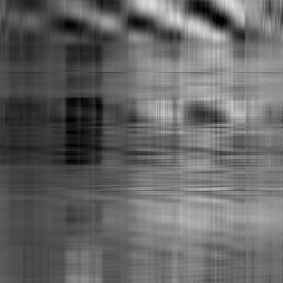

In [85]:
Gray.(img1)

As you can see, it's still far away from the original image. Let's try using 100 singular vectors/values.

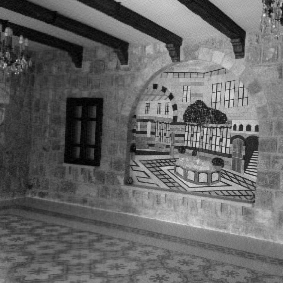

In [92]:
# Downsamples / Compresses the image
# Original image was of size 238x238
# This image is of size 100x100
i = 1:100
u1 = SVD_V.U[:,i]
v1 = SVD_V.V[:,i]
img1 = u1*spdiagm(0=>SVD_V.S[i])*v1'
Gray.(img1)

This looks almost identical to the original image, even though it's not identical to the original image (and we can see that from the norm difference).

In [94]:
norm(Xgrayvalues-img1) # norm not close to 0 => lossy compression

5.5281870959589945

Our next problem will still be related to images, but this time we will solve a simple form of the face recognition problem. Let's get the data first.

In [95]:
M = matread("data/face_recog_qr.mat")

Dict{String, Any} with 1 entry:
  "V2" => [0.08103 0.0729089 … 0.0529805 0.0594823; 0.089725 0.082329 … 0.05180…

Each vector in `M["V2"]` is a fase image. Let's reshape the first one and take a look.

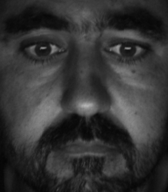

In [106]:
q = reshape(M["V2"][:,1],192,168)
Gray.(q)

Now we will go back to the vectorized version of this image, and try to select the images that are most similar to it from the "dictionary" matrix. Let's use `b = q[:]` to be the query image. Note that the notation `[:]` vectorizes a matrix column wise.

In [107]:
b = q[:]

32256-element Vector{Float64}:
 0.0810300261581645
 0.08972497847335578
 0.0873803822279144
 0.0841839709221837
 0.08923537113064388
 0.08721125794763387
 0.09061926007535659
 0.09874041385097843
 0.08932030421406685
 0.08584587638761629
 0.09319940629980634
 0.08927783767235538
 0.0994655711726987
 ⋮
 0.10334467325843819
 0.09275226549880594
 0.0846311117231841
 0.07561567634556146
 0.06385097046320852
 0.06110169995847822
 0.05023127567812609
 0.03478055114733056
 0.027342088151717514
 0.028961527075438608
 0.024761941927267744
 0.027064071630997635

We will remove the first image from the dictionary. The goal is to find the solution of the linear system `Ax=b` where `A` is the dictionary of all images. In face recognition problem we really want to minimize the norm differece `norm(Ax-b)` but the `\` actually solves a least squares problem when the matrix at hand is not invertible.

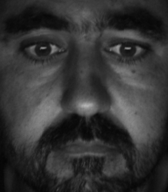

In [108]:
A = M["V2"][:,2:end]
x = A\b #Ax=b
Gray.(reshape(A*x,192,168))

In [109]:
norm(A*x-b)

8.840092371569394e-14

This was an easy problem. Let's try to make the picture harder to recover. We will add some random error.

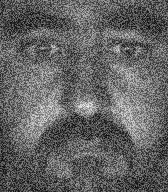

In [110]:
qv = q+rand(size(q,1),size(q,2))*0.5
qv = qv./maximum(qv)
Gray.(qv)

In [111]:
b = qv[:];

In [112]:
x = A\b
norm(A*x-b)

22.502004375036424

The error is so much bigger this time.

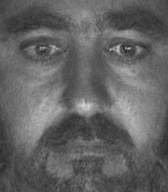

In [113]:
Gray.(reshape(A*x,192,168))

# Finally...
After finishing this notebook, you should be able to:
- [ ] reshape and vectorize a matrix
- [ ] apply basic linear algebra operations such as transpose, matrix-matrix product, and solve a linear systerm
- [ ] call a linear algebra factorization on your matrix
- [ ] use SVD to created a compressed version of an image
- [ ] solve the face recognition problem via a least square approach
- [ ] create a sparse matrix, and call the components of the Compressed Sparse Column storage
- [ ] list a few types of matrices Julia uses (diagonal, upper triangular,...)
- [ ] (unrelated to linear algebra): load an image, convert it to grayscale, and extract the RGB layers

# 🥳 One cool finding

We can solve a simple form of the face recognition problem even when a face image has been distorted with wrong pixels. Example, one of our inputs was this image: <img src="data/0201.png" width="100">

And we were able to detect this face to be closest to the input image: <img src="data/0202.png" width="100">